In [1]:
from models import preflop_model

model = preflop_model()
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 34        
Total params: 3,730
Trainable params: 3,730
Non-trainable params: 0
_________________________________________________________________


In [2]:
from pushfold import PushFoldEmulator

import numpy as np

emul = PushFoldEmulator(200,10)
num_hands = 10001
total_reward = 0

e = 0.1
loss = []

sb_pushed_plt = []
bb_called_plt = []

state_sb = np.zeros((16))
state_bb = np.zeros((16))

targetQ = np.zeros((2))

bankroll_sb = [0]
player1 = True

replay_state = []
replay_Q = []
max_replay = 30000

sb_pushed = 0
bb_called = 0


for i in range(num_hands):
    reward_sb = 0
    reward_bb = 0

  
    emul.new_hand(np.random.randint(40,400))

    emul.get_hand_feature()

    sb_features = np.concatenate([emul.players_cards[1],np.array([emul.suited[1],1,emul.starting_stack/400])]).reshape((1,16))
    bb_features = np.concatenate([emul.players_cards[0],np.array([emul.suited[0],0,emul.starting_stack/400])]).reshape((1,16))
    
    replay_state.append(sb_features.reshape((16,)))
    
    
    #run model to choose action
    allQ_sb = model.predict(sb_features)
    action_sb = np.argmax(allQ_sb)
    allQ_bb = model.predict(bb_features)
    action_bb = np.argmax(allQ_bb)

    #randomly discover new line
    if(np.random.rand(1) < e):

        action_sb = np.random.randint(0,2)
        action_bb = np.random.randint(0,2)
        
    emul.play_action(action_sb)
    if action_sb == 1:
        sb_pushed +=1
    
    if emul.is_round_finished() == False:
        emul.play_action(action_bb)     
        if action_sb == 1:
            if action_bb == 1:
                bb_called +=1
            

    r  = emul.get_sb_reward()
    total_reward +=r
    bankroll_sb.append(bankroll_sb[-1]+r)
    
    allQ_sb[0,action_sb] = r
    replay_Q.append(allQ_sb.reshape((2,)))
    
    #train only if sb played. otherwise positive reward for folding
    if action_sb == 1:
        replay_state.append(bb_features.reshape((16,)))
        allQ_bb[0,action_bb] = -r
        replay_Q.append(allQ_bb.reshape((2,)))
    

    if(i%5000== 0 and i > 0):
        sb_pushed_pct = int(sb_pushed/(i+1)*100)
        sb_pushed_plt.append(sb_pushed_pct)
        bb_called_pct = int(bb_called/(sb_pushed+1)*100)
        bb_called_plt.append(bb_called_pct)
        print('\n\nround',i)
        print('Won(SB):',r,'  Total won (SB):',total_reward)
        print('SB pushed ' + str(sb_pushed_pct)+'% , BB called '+  str(bb_called_pct)+'%' )
        print('sb_features')
        print(sb_features)
        print('allQ_sb:')
        print(allQ_sb)
        print('\nbb_features')
        print(bb_features)
        print('allQ_bb:')   
        print(allQ_bb)
        
        print(emul.get_action_histories_text(hole_cards = True))
                
        model.fit(np.stack(replay_state),np.stack(replay_Q),verbose=1,epochs=5)


    if(len(replay_state) > max_replay):
        replay_state = replay_state[50:]
        replay_Q = replay_Q[50:]


next player: 0


TypeError: must be str, not int

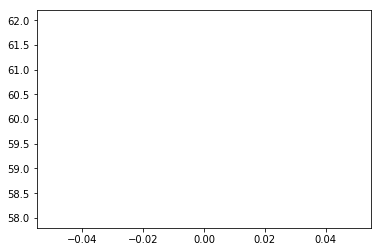

In [5]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(sb_pushed_plt[1:])
plt.plot(bb_called_plt[1:])

In [13]:
from metrics import compute_nash_pusher
from metrics import compute_nash_caller
call_nash = compute_nash_caller(model)
push_chart = compute_nash_pusher(model)

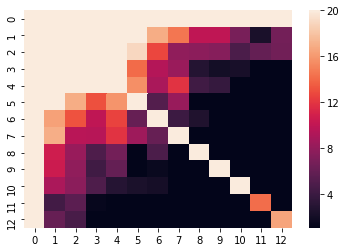

In [14]:
sns.heatmap(push_chart)

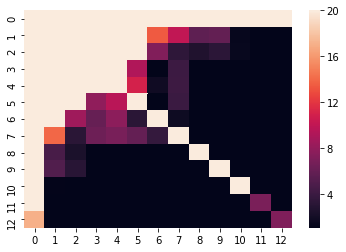

In [15]:
sns.heatmap(call_nash)

In [ ]:
call_nash


In [ ]:
from models import save_model

save_model(model,'pushfold4')

In [12]:
from models import load

model = load('pushfold')